# Data Overview

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style="whitegrid")

In [84]:
log_dir = Path('../../results/logs/raw-metadata')

In [85]:
def load_ftp_paths(log_dir, category):
    # Get the path to the txt file
    txt_file_path = list(log_dir.glob(f"./{category}_ftp_paths.txt"))
    
    # Ensure there's exactly one matching file
    if not txt_file_path:
        raise FileNotFoundError("No matching txt file found.")
    elif len(txt_file_path) > 1:
        raise ValueError("Multiple matching txt files found.")
    
    # Read the txt file into a DataFrame
    df = pd.read_csv(txt_file_path[0], header=None, names=["path"])  
    return df

In [86]:
categories = ['bacteria', 'fungi', 'viral', 'archaea', 'protozoa']

In [87]:
ftp_files = {category: load_ftp_paths(log_dir, category) for category in categories}

In [88]:
for category in categories:
    print(f'{category}: {ftp_files[category].count()}')

bacteria: path    267630
dtype: int64
fungi: path    9762
dtype: int64
viral: path    154164
dtype: int64
archaea: path    5883
dtype: int64
protozoa: path    1278
dtype: int64


In [89]:
def load_assembly_summary(file_path: Path, category: str) -> pd.DataFrame:
    """
    Load a NCBI assembly_summary.txt file, handling comment lines and headers.
    """
    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found.")
    
    # Extract the header from the comment line
    with open(file_path) as f:
        for line in f:
            if line.startswith("#assembly_accession"):
                header = line.strip("#").strip().split("\t")
                break

    # Now read the file with no header, skipping all comment lines
    df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=header, low_memory=False)
    df['category'] = category

    # Convert release date column if present
    if 'seq_rel_date' in df.columns:
        df['seq_rel_date'] = pd.to_datetime(df['seq_rel_date'], errors='coerce')

    return df

In [90]:
def load_all_summaries(metadata_dir: Path, categories: list) -> pd.DataFrame:
    dfs = []
    for category in categories:
        file_path = metadata_dir / f"{category}_assembly_summary.txt"
        try:
            df = load_assembly_summary(file_path, category)
            dfs.append(df)
        except FileNotFoundError:
            print(f"[WARNING] Missing: {file_path.name}")
    if not dfs:
        raise ValueError("No valid files loaded.")
    return pd.concat(dfs, ignore_index=True)

In [91]:
def summarize_assembly_levels(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby(['category', 'assembly_level']).size().unstack(fill_value=0)

In [92]:
def plot_submissions_over_time(df: pd.DataFrame, output_path: Path = None):
    df = df.dropna(subset=['seq_rel_date']).copy()
    df['year'] = df['seq_rel_date'].dt.year
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='year', hue='category', multiple='stack', bins=30, palette="Set2")
    plt.title("Genome Assembly Submissions Over Time by Category")
    plt.xlabel("Year")
    plt.ylabel("Number of Assemblies")
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

In [93]:
def run_metadata_analysis(metadata_dir: Path):
    categories = ["bacteria", "archaea", "viral", "protozoa"]
    
    print("[INFO] Loading metadata...")
    df = load_all_summaries(metadata_dir, categories)
    
    print("[INFO] Summarizing assembly levels...")
    summary = summarize_assembly_levels(df)
    print(summary)
    
    print("[INFO] Plotting submission trends...")
    plot_submissions_over_time(df, output_path=metadata_dir / "assembly_submission_trend.pdf")
    
    return df, summary

[INFO] Loading metadata...
[INFO] Summarizing assembly levels...
assembly_level  Chromosome  Complete Genome   Contig  Scaffold
category                                                      
archaea                120              811    16879     12740
bacteria              9219            64975  2197938    391971
protozoa               263               36      793      1318
viral                19902           200066    10347        50
[INFO] Plotting submission trends...


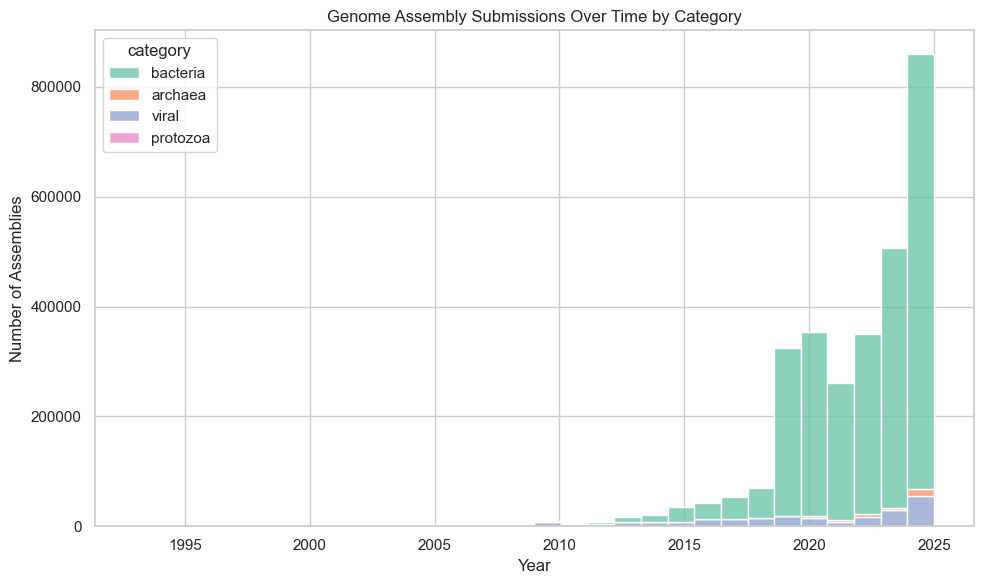

In [94]:
df, summary = run_metadata_analysis(log_dir)